<a href="https://colab.research.google.com/github/dr-mushtaq/Projects/blob/master/Emotion_Detection_in_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Table of Content**</p>



1.   Dataset
2.   Understanding What’s Inside Your Dataset
3.   Preprocessing
4.   Train our Model
5.   Model Testing
6.   Hugging Face Transformers



# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**1-Dataset**</p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
#%%
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/Courses /Data Science /NLP/Datasets/Emotion /text_emotion.csv')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**2-Understanding What’s Inside Your Dataset**</p>

In [22]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


This one’s a simple dataset with just four columns, the tweet ID, emotion depicted by the tweet, the author, and the text content of the tweet. We do not necessarily need the author column. Hence we can drop it.

In [23]:
data = data.drop('author', axis=1)


In [24]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


The dataset has 40,000 tweets in total, labeled into 13 different human sentiments. Our task here is to build a model, such that give a new tweet or text sentence, it can accurately identify which of the emotions (for which it is trained to recognize) it depicts. For this tutorial let us consider just two of these sentiments for simplicity, ‘happiness’ and ‘sadness’ (which constitute a total of about 10,000 tweets from the entire sample of data). We can thus drop rows with all other labels.

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**3-Preprocessing**</p>

Dropping rows with other emotion labels


In [25]:
# Dropping rows with other emotion labels
data = data.drop(data[data.sentiment == 'anger'].index)
data = data.drop(data[data.sentiment == 'boredom'].index)
data = data.drop(data[data.sentiment == 'enthusiasm'].index)
data = data.drop(data[data.sentiment == 'empty'].index)
data = data.drop(data[data.sentiment == 'fun'].index)
data = data.drop(data[data.sentiment == 'relief'].index)
data = data.drop(data[data.sentiment == 'surprise'].index)
data = data.drop(data[data.sentiment == 'love'].index)
data = data.drop(data[data.sentiment == 'hate'].index)
data = data.drop(data[data.sentiment == 'neutral'].index)
data = data.drop(data[data.sentiment == 'worry'].index)

In [26]:
data.head()

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


## **Data Vislization**

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='sentiment'>

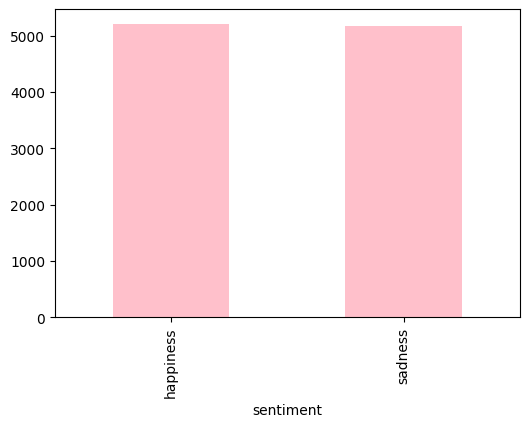

In [7]:
data['sentiment'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))


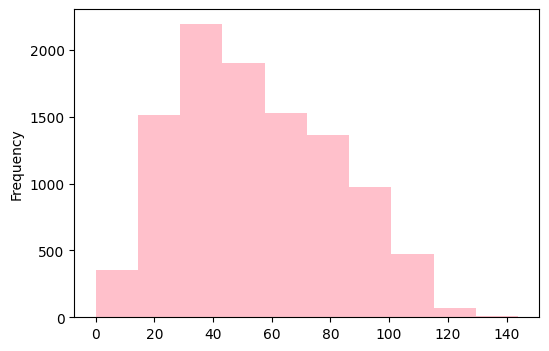

In [ ]:
# checking the distribution of tweets in the data

length_train = data['content'].str.len().plot.hist(color = 'pink', figsize = (6, 4))


In [12]:
data.head()

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,layin n bed headache ughh..waitin call..
2,1956967696,sadness,coolfunky,funeral ceremony..gloomy friday..
6,1956968487,sadness,ShansBee,"sleep, im not! thinking old friend want. he's ..."
8,1956969035,sadness,nic0lepaula,@charviray charlene love. miss
9,1956969172,sadness,Ingenue_Em,@kelcouch i'm sorry least friday?


In [28]:

# adding a column to represent the length of the tweet

data['len'] = data['content'].str.len()

In [14]:
data.head()

,tweet_id,sentiment,author,content,len
1,1956967666,sadness,wannamama,layin n bed headache ughh..waitin call..,40
2,1956967696,sadness,coolfunky,funeral ceremony..gloomy friday..,33
6,1956968487,sadness,ShansBee,"sleep, im not! thinking old friend want. he's ...",90
8,1956969035,sadness,nic0lepaula,@charviray charlene love. miss,30
9,1956969172,sadness,Ingenue_Em,@kelcouch i'm sorry least friday?,33


In [15]:


data.groupby('sentiment').describe()

tweet_id                                                          \
             count          mean           std           min           25%   
sentiment                                                                    
happiness   5209.0  1.769092e+09  9.199737e+07  1.693956e+09  1.695341e+09   
sadness     5165.0  1.928605e+09  8.350930e+07  1.693975e+09  1.957549e+09   

                                                        len             \
                    50%           75%           max   count       mean   
sentiment                                                                
happiness  1.752228e+09  1.753618e+09  1.966425e+09  5209.0  56.290075   
sadness    1.962137e+09  1.964396e+09  1.966440e+09  5165.0  53.160503   

                                                    
                 std  min   25%   50%   75%    max  
sentiment                                           
happiness  26.376501  0.0  35.0  53.0  77.0  144.0  
sadness    26.252380  0.0  32.0  51.0  73.0  134.0

## **Data Cleaning**

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
#Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#Removing Punctuation, Symbols
data['content'] = data['content'].str.replace('[^\w\s]',' ')
#Removing Stop Words using NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
#Lemmatisation
from textblob import Word
data['content'] = data['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#Correcting Letter Repetitions
import re
def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
#%%
data['content'] = data['content'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

Next consideration is the idea that if a word is appearing only once in the entire sample of data, then it most likely has no influence in determining the sentiment of the text. Hence we can remove all the rarely occurring words from the dataset which are generally proper nouns and other insignificant words with respect to the current context.

In [ ]:
# Code to find the top 10,000 rarest words appearing in the data
# Code to find the top 10,000 rarest words appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-10000:]
# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [ ]:
print(data.head())

     tweet_id sentiment                                            content
1  1956967666   sadness           layin n bed headache ughh..waitin call..
2  1956967696   sadness                                   funeral friday..
6  1956968487   sadness  sleep, im not! thinking old friend want. he's ...
8  1956969035   sadness                     @charviray charlene love. miss
9  1956969172   sadness                  @kelcouch i'm sorry least friday?


**Encode Label Categories**

Label encoding is important since most machine learning models cannot directly comprehend and analyze text labels or raw category data, we encode categories during the model-building process.

In [ ]:
#Encode label for easy identification.
data['sentiment'] = data['sentiment'].astype('category').cat.codes
print(data.head())

     tweet_id  sentiment                                            content
1  1956967666          1           layin n bed headache ughh..waitin call..
2  1956967696          1                                   funeral friday..
6  1956968487          1  sleep, im not! thinking old friend want. he's ...
8  1956969035          1                     @charviray charlene love. miss
9  1956969172          1                  @kelcouch i'm sorry least friday?


## **Feature Extraction**

Once you make the text data clean, precise, and error-free, each tweet is represented by a group of keywords. Now, we need to perform ‘Feature Extraction’, i.e extracting some parameters from the data that can be presented numerically. In this article, we consider two different features, TF-IDF & Count Vectors (Remember, we need numeric data for the math!). Split the data into training and testing parts before performing feature extraction.

In [ ]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)
# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

Term Frequency-Inverse Document Frequency (TF-IDF): This parameter gives the relative importance of a term in the data and is a measure of how frequently and rarely it appears in the text. This can be directly extracted in python as follows-

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd

In [ ]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)
# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

# Convert X_train and X_val to lists of strings
X_train = X_train.astype(str).tolist()  # Ensure each element is a string
X_val = X_val.astype(str).tolist()    # Ensure each element is a string

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True) # Pass the list of strings
val_encodings = tokenizer(X_val, truncation=True, padding=True)   # Pass the list of strings

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train  # Use y_train instead of train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val   # Use y_val instead of val_labels
))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/2
584/584 [==============================] - 103s 122ms/step - loss: 0.4486 - accuracy: 0.8034 - val_loss: 0.4127 - val_accuracy: 0.8179
Epoch 2/2
584/584 [==============================] - 70s 120ms/step - loss: 0.3104 - accuracy: 0.8770 - val_loss: 0.4594 - val_accuracy: 0.8198


In [ ]:
 model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66957317 (255.42 MB)
Trainable params: 66957317 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import load_model
save_directory = "Multitext_Classification_colab" # Change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('Multitext_Classification_colab/tokenizer_config.json',
 'Multitext_Classification_colab/special_tokens_map.json',
 'Multitext_Classification_colab/vocab.txt',
 'Multitext_Classification_colab/added_tokens.json')

In [ ]:
# Change the save_directory to the actual location where the model was saved.
# If it was saved to "Multitext_Classification_colab", use that instead:
save_directory = "Multitext_Classification_colab"

loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at Multitext_Classification_colab were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Multitext_Classification_colab and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'data' is your DataFrame and 'sentiment' column contains labels
test_labels = data['sentiment'].values

# Define test_data - You need to prepare your test data for prediction.
# This could involve tokenizing it using the loaded_tokenizer.
# Replace '...' with the appropriate code for preparing your test data
test_data = loaded_tokenizer(list(data['content']), padding=True, truncation=True, return_tensors="tf")

# Get predictions from the loaded model
y_pred_probs = loaded_model.predict(test_data)
# Assuming your model outputs probabilities, you might need to get the predicted labels:
y_pred_numerical = np.argmax(y_pred_probs.logits, axis=1) # Extract predicted labels

# Create a mapping between numerical labels and sentiment labels
# Assuming your sentiment labels are: ['happiness', 'sadness']
label_mapping = {0: 'happiness', 1: 'sadness'}

# Convert numerical predictions to sentiment labels
y_pred_labels = [label_mapping[pred] for pred in y_pred_numerical]

# Now you can use test_labels in the classification_report
print(classification_report(test_labels, y_pred_labels))


325/325 [==============================] - 25s 76ms/step
              precision    recall  f1-score   support

   happiness       0.85      0.93      0.89      5209
     sadness       0.92      0.83      0.88      5165

    accuracy                           0.88     10374
   macro avg       0.89      0.88      0.88     10374
weighted avg       0.89      0.88      0.88     10374



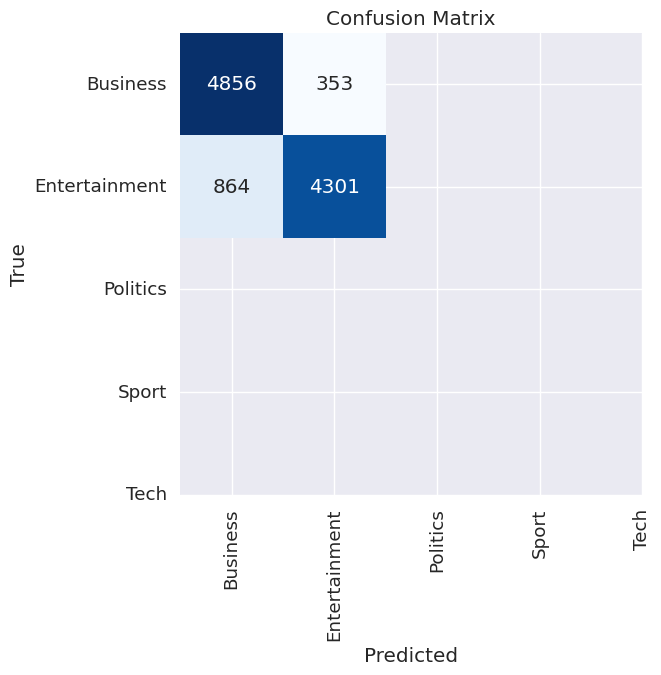

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred_labels from ipython-input-33-d34652aacf8a contains the sentiment labels (strings)
# Replace 'y_pred' with 'y_pred_labels' in the confusion_matrix function
confusion = confusion_matrix(test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"],
            yticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Extracting TF-IDF parameters
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

Count Vectors: This is another feature we consider and as the name suggests we transform our tweet into an array having the count of appearances of each word in it. The intuition here is that the text that conveys similar emotions may have the same words repeated over and over again. This is more like the direct approach.

In [ ]:
# Extracting Count Vectors Parameters
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**4-Train our Model**</p>

**Build some models using the TF-IDF features**

**1-Multinomial Naive Bayes Classifier**

In [ ]:
from sklearn.metrics import accuracy_score
# Model 1: Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes tfidf accuracy 0.5086705202312138


**Model 2: Linear SVM**

In [ ]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))

svm using tfidf accuracy 0.5616570327552987


**Model 3: logistic regression**

In [ ]:
# Model 3: logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))

log reg tfidf accuracy 0.5568400770712909


**Model 4: Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
print('random forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))

random forest tfidf accuracy 0.5529865125240848


**Build models using count vectors features-**

In [ ]:
# Model 1: Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred = nb.predict(X_val_count)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes count vectors accuracy 0.7620423892100193


In [ ]:
# Model 2: Linear SVM
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

lsvm using count vectors accuracy 0.7976878612716763


In [ ]:
# Model 3: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))

log reg count vectors accuracy 0.7928709055876686


By using count vectors, we have a significant improvement in performance. The best model, linear SVM achieved up to 79.28% accuracy.

This might be because of the nature of this specific dataset where the emotion of the text is heavily dependent on the presence of some significant adjectives.

Let us now test how it performs in reality by giving this model some random text input.

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**5-Model Testing**</p>

In [ ]:
#Below are 8 random statements.
#The first 4 depict happiness
#The last 4 depict sadness
tweets = pd.DataFrame(['I am very happy today! The atmosphere looks cheerful',
'Things are looking great. It was such a good day',
'Success is right around the corner. Lets celebrate this victory',
'Everything is more beautiful when you experience them with a smile!',
'Now this is my worst, okay? But I am gonna get better.',
'I am tired, boss. Tired of being on the road, lonely as a sparrow in the rain. I am tired of all the pain I feel',
'This is quite depressing. I am filled with sorrow',
'His death broke my heart. It was a sad day'])
# Doing some preprocessing on these tweets as done before
tweets[0] = tweets[0].str.replace('[^\w\s]',' ')
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# Extracting Count Vectors feature from our tweets
tweet_count = count_vect.transform(tweets[0])
#Predicting the emotion of the tweet using our already trained linear SVM
tweet_pred = lsvm.predict(tweet_count)
print(tweet_pred)

[0 0 0 0 1 1 1 1]


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**6-Hugging Face Transformers**</p>

Hugging Face hosts a variety of transformer-based Language Models (LMs) specialized in addressing language understanding and language generation tasks, including but not limited to:

1- Text classification

2- Named Entity Recognition (NER)

3- Text generation

4- Question-answering

5-Summarization

6- Translation

## **Loading the Language Model**


In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report

# ... (rest of your code)
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

# Step 1: Make predictions on the training and validation sets
y_train_pred = [classifier(text)[0]['label'] for text in X_train]
y_val_pred = [classifier(text)[0]['label'] for text in X_val]

# Map string labels to numerical labels if needed
label_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}
y_train_pred_numeric = [label_mapping[label] for label in y_train_pred]
y_val_pred_numeric = [label_mapping[label] for label in y_val_pred]

# Step 2: Evaluate the performance
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred_numeric)) # Use numeric labels

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred_numeric)) # Use numeric labels

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Training Set Performance:
              precision    recall  f1-score   support

           0       0.19      0.01      0.02      4688
           1       0.86      0.01      0.03      4648
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.01      9336
   macro avg       0.15      0.00      0.01      9336
weighted avg       0.52      0.01      0.02      9336

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.19      0.01      0.02       521
           1       1.00      0.01      0.03       517
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Undefin

In [ ]:
y_train_pred

['surprise',
 'neutral',
 'joy',
 'joy',
 'joy',
 'surprise',
 'joy',
 'joy',
 'sadness',
 'neutral',
 'neutral',
 'surprise',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'neutral',
 'sadness',
 'sadness',
 'neutral',
 'joy',
 'joy',
 'sadness',
 'joy',
 'sadness',
 'neutral',
 'neutral',
 'joy',
 'sadness',
 'joy',
 'sadness',
 'fear',
 'joy',
 'joy',
 'fear',
 'sadness',
 'neutral',
 'sadness',
 'anger',
 'joy',
 'joy',
 'neutral',
 'sadness',
 'neutral',
 'surprise',
 'joy',
 'joy',
 'disgust',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'surprise',
 'joy',
 'neutral',
 'neutral',
 'sadness',
 'neutral',
 'neutral',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'sadness',
 'neutral',
 'surprise',
 'surprise',
 'surprise',
 'neutral',
 'sadness',
 'joy',
 'sadness',
 'neutral',
 'neutral',
 'sadness',
 'anger',
 'sadness',
 'joy',
 'neutral',
 'surprise',
 'sadness',
 'neutral',
 'sadness',
 'surprise',


In [ ]:
#example_tweet = "I love hugging face transformers!"
prediction = classifier(y_train_pred)
print(prediction)

[{'label': 'surprise', 'score': 0.7743749022483826}, {'label': 'neutral', 'score': 0.62220299243927}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'surprise', 'score': 0.7743749022483826}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'neutral', 'score': 0.62220299243927}, {'label': 'neutral', 'score': 0.62220299243927}, {'label': 'surprise', 'score': 0.7743749022483826}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'joy', 'score': 0.9535831212997437}, {'label': 'sadness', 'score': 0.9736422896385193}, {'label': 'sad

In [ ]:
y_val_pred

['sadness',
 'joy',
 'sadness',
 'joy',
 'surprise',
 'neutral',
 'joy',
 'joy',
 'neutral',
 'joy',
 'neutral',
 'joy',
 'neutral',
 'joy',
 'surprise',
 'neutral',
 'joy',
 'joy',
 'neutral',
 'neutral',
 'joy',
 'joy',
 'neutral',
 'surprise',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'surprise',
 'neutral',
 'neutral',
 'neutral',
 'joy',
 'joy',
 'joy',
 'surprise',
 'joy',
 'sadness',
 'joy',
 'surprise',
 'disgust',
 'surprise',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'neutral',
 'joy',
 'joy',
 'surprise',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'neutral',
 'sadness',
 'surprise',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'neutral',
 'sadness',
 'sadness',
 'anger',
 'surprise',
 'sadness',
 'surprise',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'surprise',
 'neutral',
 'neutral',
 'surprise',
 'sadness',
 'anger',
 'sadness',
 'joy',
 'neutral',
 'surprise',
 'neutral',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'neutral',
 'joy',
 'surprise',
 'sadness',
 

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**7-DistilBERT**</p>

**Import all Necessary Libraries**

Let import the necessary libraries needed for this project.

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd


**Model Preparation**


At this point, we need to start building our model for categorizing the label columns.

**Split DataFrame into Feature and Label**


In [ ]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)
# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

# Convert X_train and X_val to lists of strings
X_train = X_train.astype(str).tolist()  # Ensure each element is a string
X_val = X_val.astype(str).tolist()    # Ensure each element is a string


**Download the Model needed from the Transformers Library**

Initializes a tokenizer for the DistilBERT model using the DistilBertTokenizer class from the Hugging Face transformers library.

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True) # Pass the list of strings
val_encodings = tokenizer(X_val, truncation=True, padding=True)   # Pass the list of strings

**Create TensorFlow Dataset**

We will need to create a TensorFlow Dataset object from tensors using the tf.data.Dataset.from_tensor_slices() method. This will be done for both train and validate dataset.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train  # Use y_train instead of train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val   # Use y_val instead of val_labels
))

**TFTrainer Class for Fine-tuning**

The code below uses TensorFlow to initialize and compile a sequence classification model based on the DistilBERT architecture.

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

**Train Model Using TensorFlow**

Let’s train the model in TensorFlow with early stopping, we also set the number of iterations/epochs to 2. For better accuracy, we might need to increase the number of iterations and parameter tuning.

In machine learning, early stopping is a technique used to improve a model’s generalization and performance during training by preventing overfitting.

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])


**Model Architecture Summary**

The model.summary() is used to display a neural network model architecture summary.

In [ ]:
 model.summary()


**Save Model in Local Directory**

For reusability purposes, let can save the model using the following line of code. This will create an h5 file in any desired location of your choice.

In [ ]:
from tensorflow.keras.models import load_model
save_directory = "Multitext_Classification_colab" # Change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

**Load Save Model**

We can recall the saved model for future use by using the DistilBertTokenizer library. The line of code below helps load the .h5 file in the saved directory and be reused for future used cases.

In [ ]:
# Change the save_directory to the actual location where the model was saved.
# If it was saved to "Multitext_Classification_colab", use that instead:
save_directory = "Multitext_Classification_colab"

loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

**Evaluate Model**

Now that we are done with the training of the model, we need to evaluate it using actual data and see how best it performs.

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'data' is your DataFrame and 'sentiment' column contains labels
test_labels = data['sentiment'].values

# Define test_data - You need to prepare your test data for prediction.
# This could involve tokenizing it using the loaded_tokenizer.
# Replace '...' with the appropriate code for preparing your test data
test_data = loaded_tokenizer(list(data['content']), padding=True, truncation=True, return_tensors="tf")

# Get predictions from the loaded model
y_pred_probs = loaded_model.predict(test_data)
# Assuming your model outputs probabilities, you might need to get the predicted labels:
y_pred_numerical = np.argmax(y_pred_probs.logits, axis=1) # Extract predicted labels

# Create a mapping between numerical labels and sentiment labels
# Assuming your sentiment labels are: ['happiness', 'sadness']
label_mapping = {0: 'happiness', 1: 'sadness'}

# Convert numerical predictions to sentiment labels
y_pred_labels = [label_mapping[pred] for pred in y_pred_numerical]

# Now you can use test_labels in the classification_report
print(classification_report(test_labels, y_pred_labels))

**Confusion Matrix**

In machine learning, a confusion matrix is a tool used to assess how well categorization algorithms perform. This is due to the fact it offers a more detailed picture of a model’s accuracy than just a simple overall percentage.

Let’s start by creating a function for making predictions on text data using a loaded tokenizer and a loaded model.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_pred_labels from ipython-input-33-d34652aacf8a contains the sentiment labels (strings)
# Replace 'y_pred' with 'y_pred_labels' in the confusion_matrix function
confusion = confusion_matrix(test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"],
            yticklabels=["Business", "Entertainment", "Politics", "Sport", "Tech"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **References**

[1-Using Hugging Face Transformers for Emotion Detection in Text](https://www.kdnuggets.com/using-hugging-face-transformers-for-emotion-detection-in-text?fbclid=IwY2xjawExY0BleHRuA2FlbQIxMAABHZ3RbcIRCZTEwZn3IQ1nd-4dHcP9OgD6dSGZ8sP9u4B4C5CSU4Gep7JNig_aem_ckeIZhX121O4XrywLl_V1A)

[2-How to Handle Large Text Inputs with Longformer and Hugging Face Transformers](https://www.kdnuggets.com/how-to-handle-large-text-inputs-with-longformer-and-hugging-face-transformers)

[3-DistilBERT for Multiclass Text Classification Using Transformers](https://medium.com/@kiddojazz/distilbert-for-multiclass-text-classification-using-transformers-d6374e6678ba)

[4-Twitter-Sentiment-Analysis](https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/tree/master)